In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BASE_PATH = '/Users/vinay/ub/spring-22/CSE573-CVIP/BackgroundStitching/images'

In [3]:
sift = cv2.SIFT_create()

class Recognition:
    def __init__(self, feature_detector):
        self.feature_detector = feature_detector
        self.bf = cv2.BFMatcher()
        
    def get_features(self, img):
        return self.feature_detector.detectAndCompute(img, None)
        
    def match_bf(self, img1, img2, n=20, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance, reverse=False)

        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (matches, (kp_1, kp_2)), img
    
    def match_f(self, img1, img2, n=20, r=0.7, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(dsc_1, dsc_2, k=2)
        good_matches = []
        
        for p, q in matches:
            if p.distance < r * q.distance:
                good_matches.append(p)
        
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, good_matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (good_matches, (kp_1, kp_2)), img
    
recog = Recognition(sift)

def compute_homography(args, img1, img2, min_matches=5):
    img1 = img1.copy()
    img2 = img2.copy()
    (matches, (kp1, kp2)) = args
    
    assert len(matches) >= min_matches, f'Need at least {min_matches} matches'

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, homography)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2,
    )
    op = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return homography, op
        

def resize(img, factor):
    h, w = img.shape
    op = cv2.resize(img, (int(w*factor), int(h*factor)))
    return op

def show(img, dpi=100, disable_axis=True, color=True):
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.figure(dpi=dpi)
    plt.imshow(img, cmap='gray')
    
    if disable_axis:
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

In [4]:
# img1_c = cv2.imread(f'{BASE_PATH}/left_k.JPG')
# img2_c = cv2.imread(f'{BASE_PATH}/right_k.JPG')

img1_c = cv2.imread(f'{BASE_PATH}/t1_1.png')
img2_c = cv2.imread(f'{BASE_PATH}/t1_2.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_1.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_1.png')

img1 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)

h1, w1 = img1.shape
h2, w2 = img2.shape

scale_factor = 1.0

if scale_factor != 1.0:
    img1 = resize(img1, scale_factor)
    img2 = resize(img2, scale_factor)

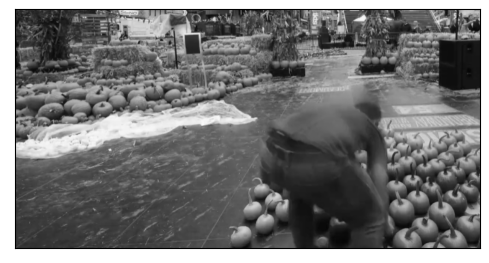

In [5]:
show(img1)

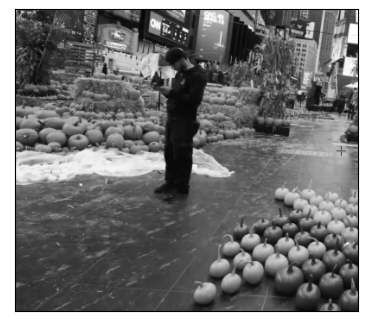

In [6]:
show(img2)

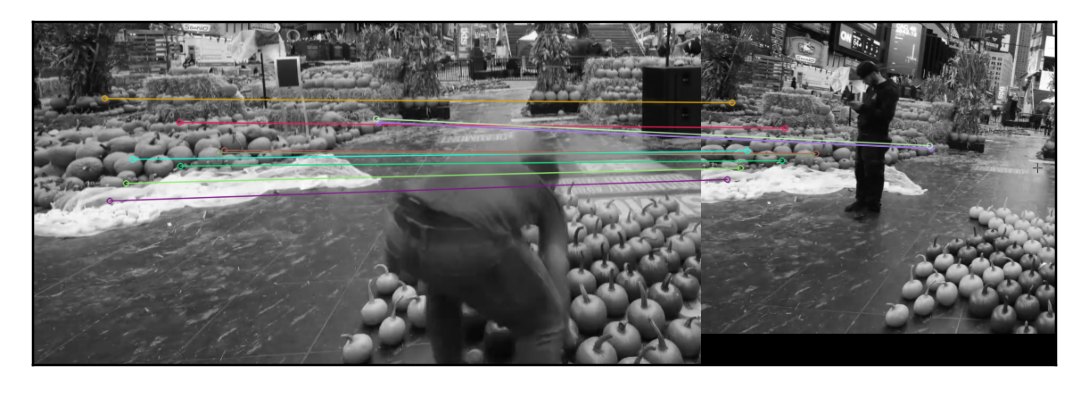

In [7]:
(matches, (kp1, kp2)), match_img = recog.match_bf(img1, img2, 10, 1)
show(match_img, dpi=220)

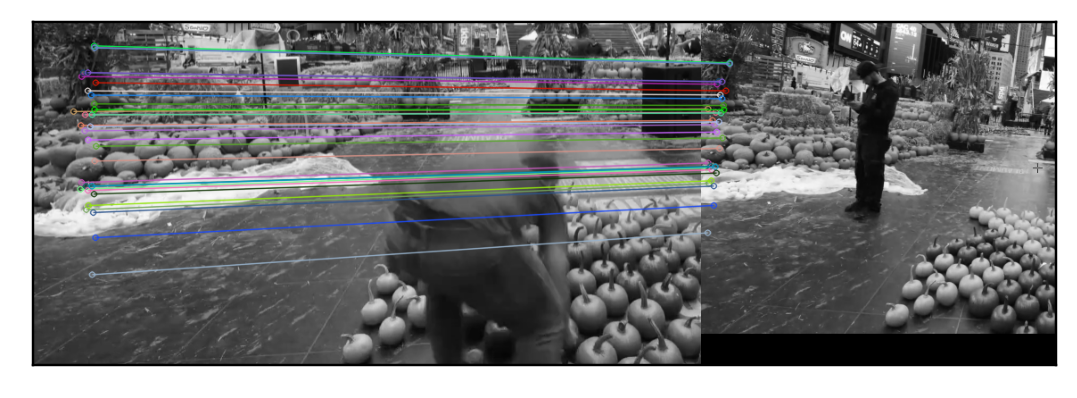

In [8]:
(matches, (kp1, kp2)), match_img = recog.match_f(img1, img2, 30, 0.60, 1)
show(match_img, dpi=220)

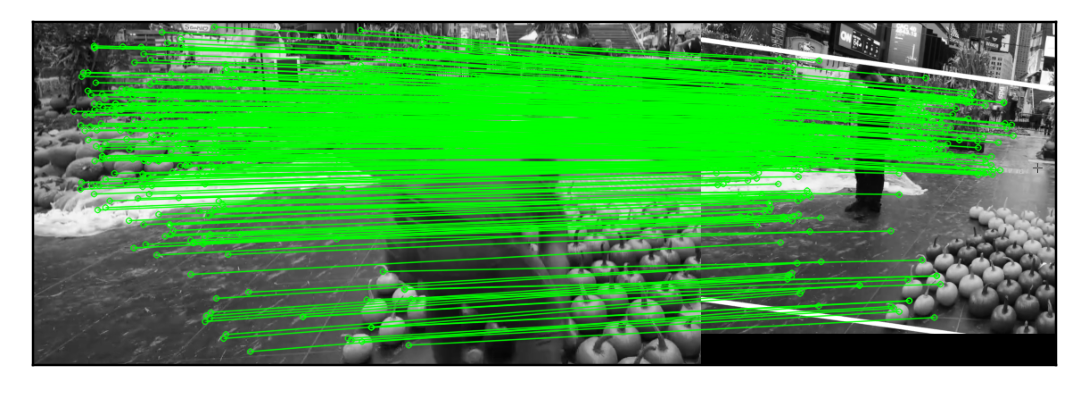

In [9]:
h, h_img = compute_homography((matches, (kp1, kp2)), img1, img2)
show(h_img, dpi=220)

In [10]:
h

array([[ 7.36666932e-01, -8.56849884e-02, -1.70196060e+01],
       [ 1.02857873e-01,  7.45675026e-01,  1.84987637e+01],
       [ 6.57513616e-06, -1.37406613e-06,  1.00000000e+00]])

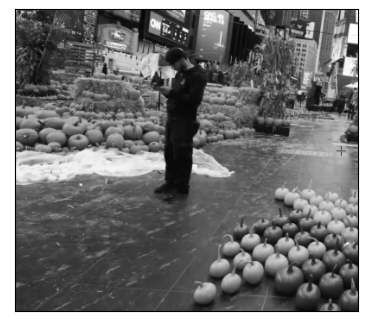

In [11]:
show(img2, dpi=100)

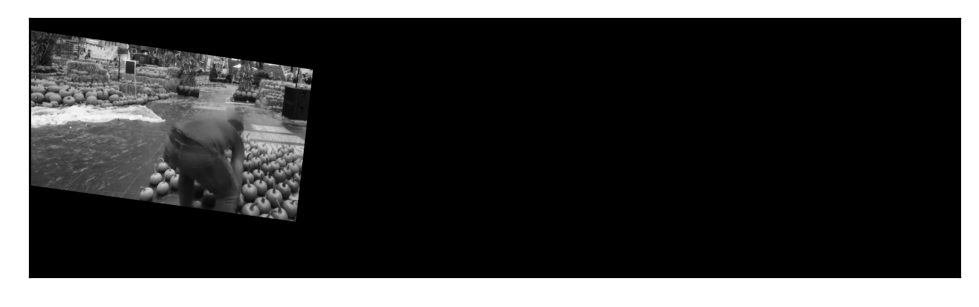

In [12]:
w_img = cv2.warpPerspective(img1, h, (img1.shape[1]+1000, img1.shape[0]+100))
show(w_img, dpi=200)

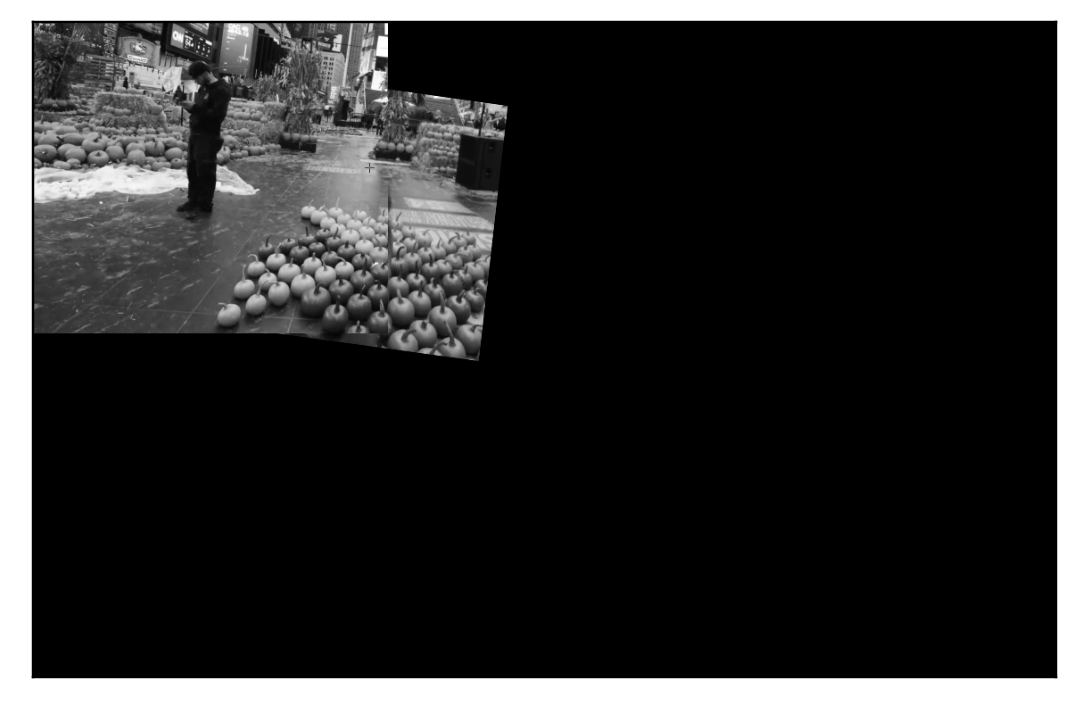

In [13]:
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, h, (width, height))
result[0:img2.shape[0], 0:img2.shape[1]] = img2

show(result, dpi=220)

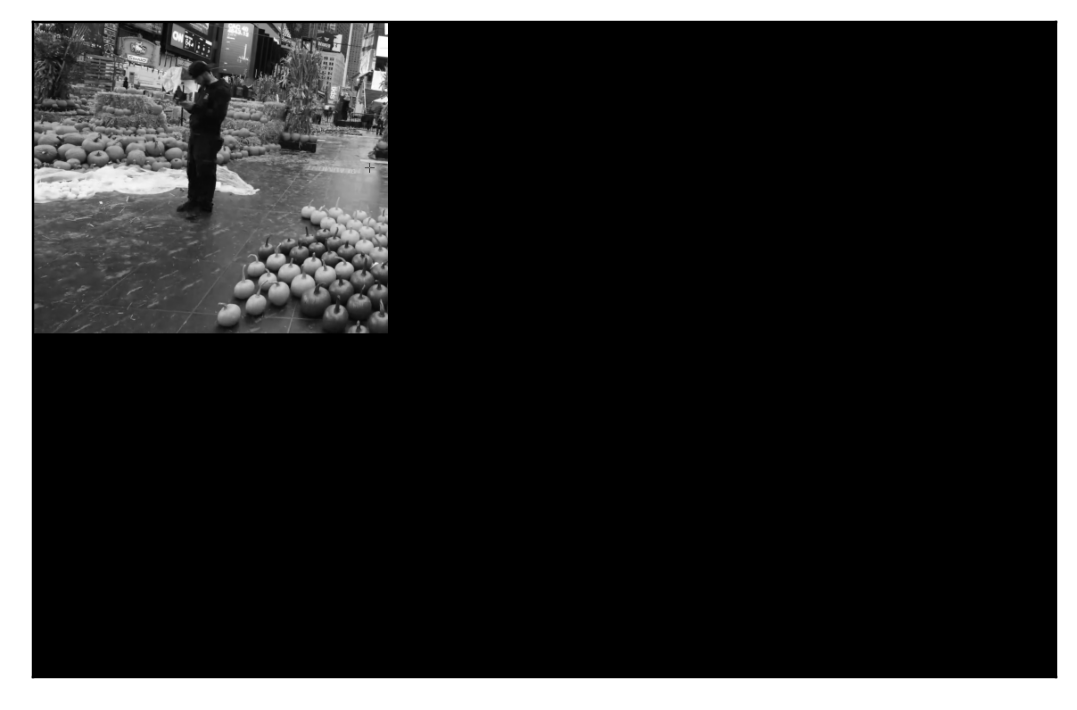

In [14]:
temp = np.zeros((height, width), dtype=np.uint8)
temp[0:img2.shape[0], 0:img2.shape[1]] = img2

show(temp, dpi=220)

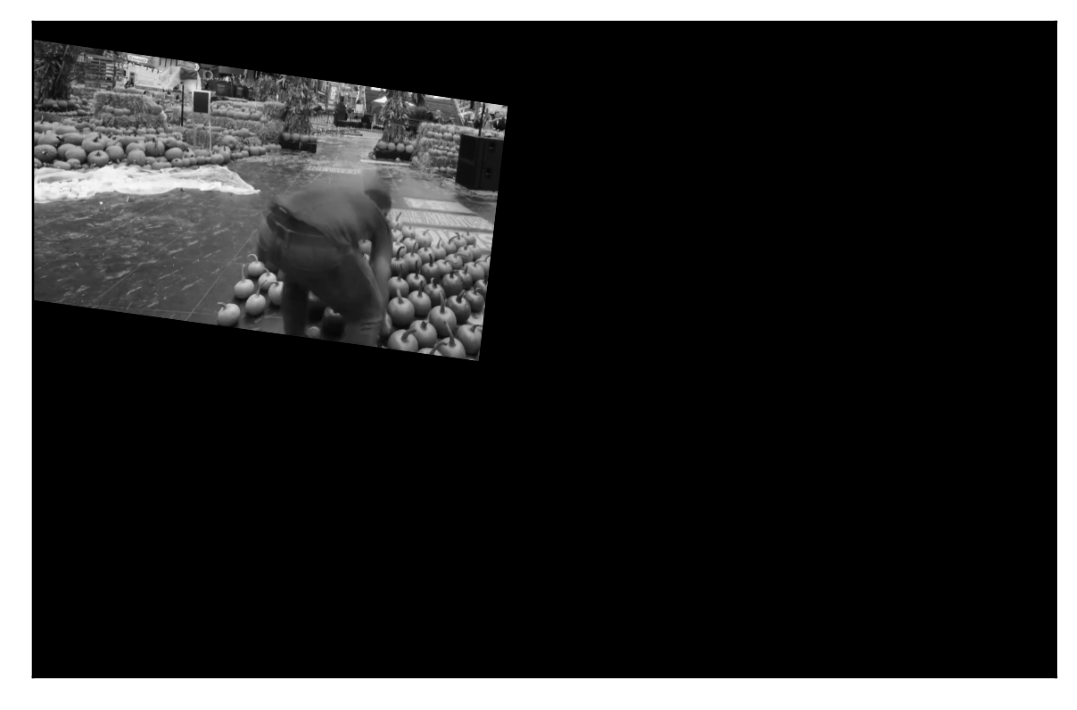

In [15]:
temp2 = cv2.warpPerspective(img1, h, (width, height))
show(temp2, dpi=220)

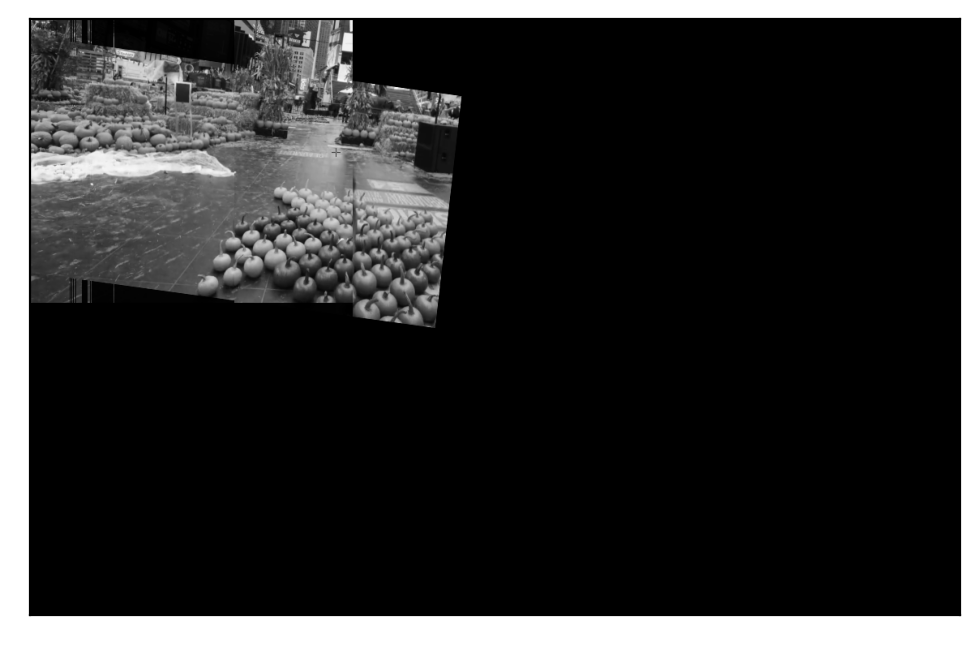

In [22]:
def merge(img1, img2, window_sz, p=0.8):
    h, w = img1.shape
    res = np.zeros((h, w), dtype=np.uint8)
    
    for i in range(w):
        if (img1[:, i] == 0.0).all():
            res[:, i] = img2[:, i]
        elif (img2[:, i] == 0.0).all():
            res[:, i] = img1[:, i]
        else:
            if i == 0:
                res[:, i] = img1[:, i]
            else:
                for j in range(0, h, window_sz):
                    i1w = img1[j:j+window_sz, i]
                    i2w = img2[j:j+window_sz, i]
                    prev_res_w = res[j:j+window_sz, i-1]
                    
                    d1 = np.abs(i1w - prev_res_w).mean()
                    d2 = np.abs(i2w - prev_res_w).mean()
                    
                    if d1 < d2:
                        res[j:j+window_sz, i] = (p * i1w) + ((1-p) * i2w)
                    else:
                        res[j:j+window_sz, i] = (p * i2w) + ((1-p) * i1w)
            
    return res
    
x = merge(temp, temp2, img1.shape[0], 0.95)
show(x, dpi=200)